# A generational model of support for gun control

Allen Downey

[MIT License](https://en.wikipedia.org/wiki/MIT_License)

In [1]:
# Configure Jupyter so figures appear in the notebook
%matplotlib inline

# Configure Jupyter to display the assigned value after an assignment
%config InteractiveShell.ast_node_interactivity='last_expr_or_assign'

import pandas as pd
import numpy as np

from empyrical_dist import Cdf
import utils

import matplotlib.pyplot as plt

import seaborn as sns
sns.set(style='white', context='talk')

## Load and inventory

Reading data from the [General Social Survey](https://gssdataexplorer.norc.org/projects/29853)

You can get my selected subset of variables from 
https://gssdataexplorer.norc.org/projects/48515

In [2]:
gss = utils.read_gss('gss_gun')
print(gss.shape)
gss.head()

(64814, 25)


,year,gunage,gunnum,owngun,rowngun,realinc,conrinc,hispanic,cohort,ballot,...,age,educ,sex,race,income,rincome,srcbelt,polviews,natcrime,adults
0,1972,0,0,0,0,18951.0,0.0,0,1949,0,...,23,16,2,1,0,0,3,0,0,1
1,1972,0,0,0,0,24366.0,0.0,0,1902,0,...,70,10,1,1,0,0,3,0,0,2
2,1972,0,0,0,0,24366.0,0.0,0,1924,0,...,48,12,2,1,0,0,3,0,0,2
3,1972,0,0,0,0,30458.0,0.0,0,1945,0,...,27,17,2,1,0,0,3,0,0,2
4,1972,0,0,0,0,50763.0,0.0,0,1911,0,...,61,12,2,1,0,0,3,0,0,2


In [3]:
def replace_invalid(df):
    df.gunlaw.replace([8, 9, 0], np.nan, inplace=True)
    df.owngun.replace([3, 8, 9, 0], np.nan, inplace=True)
    df.gun.replace([8, 9, 0], np.nan, inplace=True)
    df.natcrime.replace([8, 9, 0], np.nan, inplace=True)
    df.income.replace([0, 13, 98, 99], np.nan, inplace=True)
    df.realinc.replace([0], np.nan, inplace=True)                  # TODO: check this
    df.educ.replace([98,99], np.nan, inplace=True)
    df.polviews.replace([8, 9, 0], np.nan, inplace=True)
    df.age.replace([98, 99], np.nan, inplace=True)               # 89 means 89 or older
    df.hispanic.replace([98, 99, 0], np.nan, inplace=True)
    df.cohort.replace([9999], np.nan, inplace=True)

In [4]:
replace_invalid(gss)
gss.shape

(64814, 25)

In [5]:
def numnull(series):
    return sum(series.isnull())

### Variable `gunlaw`

Would you favor or oppose a law which would require a person to obtain a police permit before he or she could buy a gun?

https://gssdataexplorer.norc.org/projects/41723/variables/272/vshow

In [6]:
numnull(gss.gunlaw)

22801

In [7]:
utils.values(gss, 'gunlaw')

1.0    32038
2.0     9975
Name: gunlaw, dtype: int64

### Variable `owngun`

Do you happen to have in your home (IF HOUSE: or garage) any guns or revolvers?

https://gssdataexplorer.norc.org/projects/41723/variables/679/vshow

In [8]:
numnull(gss.owngun)

25644

In [9]:
utils.values(gss, 'owngun')

1.0    15659
2.0    23511
Name: owngun, dtype: int64

### Variable `gun`

Have you ever been threatened with a gun, or shot at? 

https://gssdataexplorer.norc.org/projects/41723/variables/661/vshow

In [10]:
numnull(gss.gun)

45486

In [11]:
utils.values(gss, 'gun')

1.0     3775
2.0    15553
Name: gun, dtype: int64

### Variable `natcrime`

We are faced with many problems in this country, none of which can be solved easily or inexpensively. I'm going to name some of these problems, and for each one I'd like you to name some of these problems, and for each one I'd like you to tell me whether you think we're spending too much money on it, too little money, or about the right amount. First (READ ITEM A) . . . are we spending too much, too little, or about the right amount on (ITEM)? 
E. Halting the rising crime rate

[Note: the wording of this question assumes that crime rates are rising!]

https://gssdataexplorer.norc.org/projects/41723/variables/185/vshow

In [12]:
numnull(gss.natcrime)

29279

In [13]:
utils.values(gss, 'natcrime')

1.0    23971
2.0     9384
3.0     2180
Name: natcrime, dtype: int64

### Variable `income`

In which of these groups did your total family income, from all sources, fall last year before taxes, that is?



In [14]:
varname = 'income'
numnull(gss[varname])

8326

In [15]:
utils.values(gss, varname)

1.0       799
2.0      1329
3.0      1272
4.0      1167
5.0      1281
6.0      1223
7.0      1281
8.0      2191
9.0      6496
10.0     5046
11.0     5187
12.0    29216
Name: income, dtype: int64

In [16]:
gss[varname].describe()

count    56488.000000
mean        10.068546
std          2.835886
min          1.000000
25%          9.000000
50%         12.000000
75%         12.000000
max         12.000000
Name: income, dtype: float64

### Variable `realinc`

Family income on 1972-2006 surveys in constant dollars (base = 1986)

https://gssdataexplorer.norc.org/variables/5198/vshow


In [17]:
varname = 'realinc'
numnull(gss[varname])

6521

In [18]:
gss[varname].describe()

count     58293.000000
mean      31714.223806
std       29471.362947
min         227.000000
25%       12080.625000
50%       24097.500000
75%       39875.000000
max      162607.000000
Name: realinc, dtype: float64

### Variable `educ`

A. What is the highest grade in elementary school or high school that (you/your father/ your mother/your [husband/wife]) finished and got credit for? CODE EXACT GRADE. 
B. IF FINISHED 9th-12th GRADE OR DK*: Did (you/he/she) ever get a high school diploma or a GED certificate? [SEE D BELOW.] [See REMARKS] 
C. Did (you/he/she) complete one or more years of college for credit--not including schooling such as business college, technical or vocational school? IF YES: How many years did (you/he/she) complete? 
Do you (Does [he/she]) have any college degrees? (IF YES: What degree or degrees?) CODE HIGHEST DEGREE EARNED.

https://gssdataexplorer.norc.org/projects/41723/variables/55/vshow


In [19]:
varname = 'educ'
numnull(gss[varname])

177

In [20]:
utils.values(gss, varname)

0.0       165
1.0        47
2.0       152
3.0       257
4.0       319
5.0       402
6.0       828
7.0       879
8.0      2724
9.0      2083
10.0     2880
11.0     3743
12.0    19663
13.0     5360
14.0     7160
15.0     2910
16.0     8355
17.0     1967
18.0     2384
19.0      920
20.0     1439
Name: educ, dtype: int64

### Variable `polviews`


A. We hear a lot of talk these days about liberals and conservatives. 
I'm going to show you a seven-point scale on which the political views that people might hold are arranged from extremely liberal--point 1--to extremely conservative--point 7. Where would you place yourself on this scale?

https://gssdataexplorer.norc.org/projects/41723/variables/178/vshow

In [21]:
varname = 'polviews'
numnull(gss[varname])

9486

In [22]:
utils.values(gss, varname)

1.0     1682
2.0     6514
3.0     7010
4.0    21370
5.0     8690
6.0     8230
7.0     1832
Name: polviews, dtype: int64

### Age 

https://gssdataexplorer.norc.org/projects/29853/variables/53/vshow

In [23]:
numnull(gss.age)

228

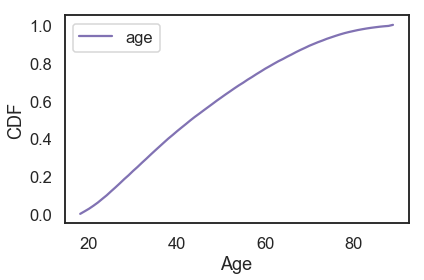

In [24]:
Cdf.from_seq(gss.age).plot()
utils.decorate(xlabel='Age', ylabel='CDF')

### Year of birth 

https://gssdataexplorer.norc.org/projects/29853/variables/5507/vshow

In [25]:
numnull(gss.cohort)

228

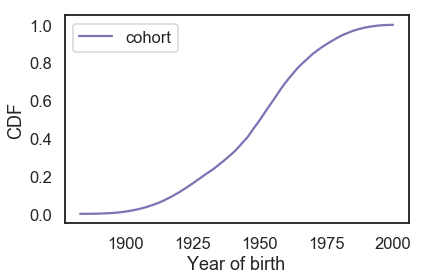

In [26]:
Cdf.from_seq(gss.cohort).plot()
utils.decorate(xlabel='Year of birth', ylabel='CDF')

In [27]:
utils.values(gss, 'cohort')

1883.0      2
1884.0      3
1885.0      7
1886.0      4
1887.0     13
1888.0     10
1889.0     21
1890.0     27
1891.0     27
1892.0     31
1893.0     34
1894.0     61
1895.0     55
1896.0     73
1897.0     72
1898.0    105
1899.0    123
1900.0    130
1901.0    138
1902.0    163
1903.0    173
1904.0    182
1905.0    219
1906.0    207
1907.0    263
1908.0    246
1909.0    330
1910.0    285
1911.0    318
1912.0    348
         ... 
1971.0    689
1972.0    679
1973.0    640
1974.0    638
1975.0    570
1976.0    565
1977.0    576
1978.0    498
1979.0    547
1980.0    488
1981.0    468
1982.0    398
1983.0    365
1984.0    376
1985.0    352
1986.0    292
1987.0    268
1988.0    232
1989.0    245
1990.0    179
1991.0    180
1992.0    123
1993.0    136
1994.0    120
1995.0     87
1996.0     72
1997.0     61
1998.0     22
1999.0     26
2000.0     22
Name: cohort, Length: 118, dtype: int64

### Sex 

https://gssdataexplorer.norc.org/projects/41723/variables/81/vshow

In [28]:
numnull(gss.sex)

0

In [29]:
utils.values(gss, 'sex')

1    28614
2    36200
Name: sex, dtype: int64

### Race

https://gssdataexplorer.norc.org/projects/41723/variables/82/vshow

CODE WITHOUT ASKING ONLY IF THERE IS NO DOUBT IN YOUR MIND. 
What race do you consider yourself? RECORD VERBATIM AND CODE.

In [30]:
numnull(gss.race)

0

In [31]:
utils.values(gss, 'race')

1    52033
2     9187
3     3594
Name: race, dtype: int64

### Hispanic 



In [32]:
numnull(gss.hispanic)

38164

In [33]:
utils.values(gss, 'hispanic')

1.0     23555
2.0      1885
3.0       384
4.0       130
5.0        98
6.0        66
7.0        15
8.0        19
9.0         4
10.0       27
11.0       41
15.0       73
16.0        1
20.0       27
21.0       38
22.0       41
23.0       14
24.0       12
25.0        4
30.0      136
31.0        2
35.0        7
40.0        5
41.0       24
42.0        1
45.0        3
46.0       12
47.0       16
50.0       10
Name: hispanic, dtype: int64

### srcbelt

C. SRC (SURVEY RESEARCH CENTER, UNIVERSITY OF MICHIGAN) NEW BELT CODE

https://gssdataexplorer.norc.org/projects/41723/variables/121/vshow

In [34]:
numnull(gss.srcbelt)

0

In [35]:
utils.values(gss, 'srcbelt')

1     5805
2     9015
3     7445
4     9786
5    24324
6     8439
Name: srcbelt, dtype: int64

## Remove rows missing key variables

In [36]:
gss.shape

(64814, 25)

In [37]:
gss = gss.dropna(subset=['gunlaw', 'age', 'cohort'])
gss.shape

(41878, 25)

## Optionally, cut off 2018 data

In [38]:
cutoff = False

False

In [39]:
if cutoff:
    cutoff_year = 2016
    gss = gss[gss.year <= cutoff_year];

In [40]:
gss.shape

(41878, 25)

## Fill missing values

In [41]:
def fill_missing_column(df, colname):
    """Fills missing values of the given column.

    df: DataFrame
    colname: string
    """
    null = df[df[colname].isnull()]

    #print(colname, len(null))

    valid = df[colname].dropna()
    fill = valid.sample(len(null), replace=True)
    fill.index = null.index

    df[colname].fillna(fill, inplace=True)

In [42]:
def fill_age(df):
    """Fills age based on year and cohort.
    
    df: DataFrame
    """
    colname = 'age'
    null = df[df[colname].isnull()]

    #print('age', len(null))
    
    fill = df.year - df.cohort

    df[colname].fillna(fill, inplace=True)

In [43]:
def fill_all_missing(df):
    varnames = ['owngun', 'gun', 'natcrime',
                'income', 'realinc', 'educ', 'polviews',
                'sex', 'race', 'hispanic', 'srcbelt']
    for varname in varnames:
        fill_missing_column(df, varname)
        
    # filling age is special because we have to fill cohort
    # to be consistent
    # but for generational analysis, we shouldn't fill age;
    # it just messes things up
    # fill_age(df)

In [44]:
fill_all_missing(gss)

### Make age and cohort groups

In [45]:
def RoundIntoBins(df, var, bin_width, high=None, low=0):
    """Rounds values down to the bin they belong in.

    df: DataFrame
    var: string variable name
    bin_width: number, width of the bins

    returns: array of bin values
    """
    if high is None:
        high = df[var].max()

    bins = np.arange(low, high+bin_width, bin_width)
    indices = np.digitize(df[var], bins)
    return bins[indices-1]

In [46]:
if cutoff:
    def make_groups(gss):
        gss['cohort5'] = utils.RoundIntoBins(gss, 'cohort', 5, low=2) + 2.5    
        gss.loc[gss.cohort5==1999.5, 'cohort5'] = 1994.5
        gss.loc[gss.cohort5<1894, 'cohort5'] = 1894.5
        gss['cohort10'] = utils.RoundIntoBins(gss, 'cohort', 10)
        gss['year8'] = utils.RoundIntoBins(gss, 'year', 8)
        gss['year4'] = utils.RoundIntoBins(gss, 'year', 4, low=1970) + 1
        gss['age10'] = utils.RoundIntoBins(gss, 'age', 10) + 5
        gss['age5'] = utils.RoundIntoBins(gss, 'age', 5) + 2.5
        gss['age3'] = utils.RoundIntoBins(gss, 'age', 3, low=0) + 1.5
else:
    def make_groups(gss):
        gss['cohort5'] = utils.RoundIntoBins(gss, 'cohort', 5, low=2) + 2.5    
        gss.loc[gss.cohort5==1999.5, 'cohort5'] = 1994.5
        gss.loc[gss.cohort5<1894, 'cohort5'] = 1894.5
        gss['cohort10'] = utils.RoundIntoBins(gss, 'cohort', 10)
        gss.loc[gss.cohort10==2000, 'cohort10'] = 1990
        gss['year8'] = utils.RoundIntoBins(gss, 'year', 8)
        gss['year4'] = utils.RoundIntoBins(gss, 'year', 4, low=1972) + 1
        gss['age10'] = utils.RoundIntoBins(gss, 'age', 10) + 5
        gss['age5'] = utils.RoundIntoBins(gss, 'age', 5) + 2.5
        gss['age3'] = utils.RoundIntoBins(gss, 'age', 3, low=0) + 1.5

In [47]:
make_groups(gss)
gss.shape

(41878, 32)

Group people into 5- and 10-year bins by birth year.

In [48]:
grouped_cohort = gss.groupby(['cohort5'])
counts = grouped_cohort.gunlaw.count()

cohort5
1894.5     316
1899.5     443
1904.5     722
1909.5    1089
1914.5    1500
1919.5    1837
1924.5    2145
1929.5    2176
1934.5    2360
1939.5    2666
1944.5    3404
1949.5    4376
1954.5    4247
1959.5    3845
1964.5    3061
1969.5    2340
1974.5    1772
1979.5    1417
1984.5    1033
1989.5     707
1994.5     422
Name: gunlaw, dtype: int64

In [49]:
grouped_cohort = gss.groupby(['cohort10'])
counts = grouped_cohort.gunlaw.count()

cohort10
1880.0      53
1890.0     502
1900.0    1563
1910.0    3024
1920.0    4230
1930.0    4762
1940.0    7106
1950.0    8438
1960.0    5967
1970.0    3535
1980.0    2053
1990.0     645
Name: gunlaw, dtype: int64

Here's the number of respondents in each year.

In [50]:
utils.values(gss, 'year')

1972    1559
1973    1467
1974    1453
1975    1445
1976    1467
1977    1492
1980    1430
1982    1804
1984    1424
1985    1504
1987    1769
1988     944
1989    1012
1990     898
1991     975
1993    1051
1994    1953
1996    1878
1998    1835
2000    1807
2002     913
2004     889
2006    1958
2008    1329
2010    1269
2012    1278
2014    1686
2016    1850
2018    1539
Name: year, dtype: int64

Group into 4 year intervals.

In [51]:
utils.values(gss, 'year4')

1973    5924
1977    2959
1981    3234
1985    4697
1989    3829
1993    3004
1997    3713
2001    2720
2005    2847
2009    2598
2013    2964
2017    3389
Name: year4, dtype: int64

Group people into 5 and 3-year age groups.

In [52]:
utils.values(gss, 'age5')

17.5     734
22.5    3709
27.5    4507
32.5    4487
37.5    4289
42.5    3916
47.5    3562
52.5    3330
57.5    3080
62.5    2777
67.5    2519
72.5    1987
77.5    1481
82.5     856
87.5     644
Name: age5, dtype: int64

In [53]:
utils.values(gss, 'age3')

19.5    1358
22.5    2277
25.5    2563
28.5    2752
31.5    2713
34.5    2634
37.5    2632
40.5    2396
43.5    2317
46.5    2123
49.5    2118
52.5    2032
55.5    1870
58.5    1829
61.5    1733
64.5    1579
67.5    1507
70.5    1350
73.5    1114
76.5     975
79.5     718
82.5     509
85.5     380
88.5     399
Name: age3, dtype: int64

### Make booleans

In [54]:
def copy_nan(df, varname, newvar):
    """Put a NaN into newvar in any place where varname is Nan.
    
    df: DataFrame
    varname: string old var name
    newvar: string new var name
    """
    df.loc[df[varname].isnull(), newvar] = np.nan

In [55]:
def make_boolean(df, varname, values, newvar):
    """Make a boolean variable.
    
    df: DataFrame
    varname: name of base variable
    values: sequence of values for varname
    newvar: name of new variable (recode)
    """
    #assert numnull(df[varname]) == 0
    df[newvar] = df[varname].isin(values)
    copy_nan(df, varname, newvar)

In [56]:
def make_booleans(df):
    df['cohort10'] = utils.RoundIntoBins(df, 'cohort', 10)
    make_boolean(df, 'cohort10', [1920], 'twenties')
    make_boolean(df, 'cohort10', [1930], 'thirties')
    make_boolean(df, 'cohort10', [1940], 'forties')
    make_boolean(df, 'cohort10', [1950], 'fifties')
    make_boolean(df, 'cohort10', [1960], 'sixties')
    make_boolean(df, 'cohort10', [1970], 'seventies')
    make_boolean(df, 'cohort10', [1980], 'eighties')
    make_boolean(df, 'cohort10', [1990], 'nineties')
    make_boolean(df, 'gunlaw', [1.0], 'favor')
    make_boolean(df, 'owngun', [1.0], 'gunhome')
    make_boolean(df, 'gun', [1.0], 'threatened')
    make_boolean(df, 'natcrime', [1.0], 'spendcrime')
    make_boolean(df, 'income', [12], 'topincome')
    make_boolean(df, 'income', [1,2,3,4,5,6,7,8], 'lowincome')
    make_boolean(df, 'polviews', [1,2,3], 'liberal')
    make_boolean(df, 'polviews', [4], 'moderate')
    make_boolean(df, 'polviews', [6,7,8], 'conservative')
    make_boolean(df, 'sex', [2], 'female')
    make_boolean(df, 'hispanic', [2], 'ishisp')
    make_boolean(df, 'race', [2], 'black')
    make_boolean(df, 'race', [3], 'otherrace')
    make_boolean(df, 'srcbelt', [1,2,5], 'urban')
    make_boolean(df, 'srcbelt', [3,4], 'suburban')
    make_boolean(df, 'srcbelt', [6], 'rural')

    df['college'] = df['educ'] >= 13 
    copy_nan(df, 'educ', 'college')
    
    quantile25 = df['realinc'].quantile(0.25)
    df['lowrealinc'] = df['realinc'] <= quantile25 
    copy_nan(df, 'realinc', 'lowrealinc')

    quantile75 = df['realinc'].quantile(0.75)
    df['highrealinc'] = df['realinc'] >= quantile75 
    copy_nan(df, 'realinc', 'highrealinc')

In [57]:
make_booleans(gss)

### Center cohort, age, and year.

In [58]:
def center_factors(df):
    """Center factors around their means.
    
    Add centered factors to make the coeffients
    of the model easier to interpret.
    
    df: DataFrame
    """
    df['ones'] = np.ones_like(df.cohort)
    df['c'] = df.cohort - 1966
    df['a'] = df.age - 47
    df['y'] = df.year - 1990
    
    # also add quadratic factors and interaction term
    df['c2'] = df.c**2
    df['a2'] = df.a**2
    df['y2'] = df.y**2
    df['y3'] = df.y**3
    df['ac'] = df.a * df.c

In [59]:
center_factors(gss)

In [60]:
for varname in ['c', 'a', 'y']:
    print(varname, gss[varname].mean())

c -18.849777926357515
a -1.0722097521371603
y 3.0780123215053248


### Resample

Divide the sample up by year; resample within each year, using sampling weights; then concatenate the annual samples.

In [61]:
sample = utils.resample_by_year(gss).copy()
sample.shape

(41878, 68)

In [62]:
utils.values(sample, 'twenties')

0.0    37676
1.0     4202
Name: twenties, dtype: int64

In [63]:
utils.values(sample, 'thirties')

0.0    37146
1.0     4732
Name: thirties, dtype: int64

In [64]:
utils.values(sample, 'forties')

0.0    34922
1.0     6956
Name: forties, dtype: int64

In [65]:
utils.values(sample, 'fifties')

0.0    33439
1.0     8439
Name: fifties, dtype: int64

In [66]:
utils.values(sample, 'sixties')

0.0    35540
1.0     6338
Name: sixties, dtype: int64

In [67]:
utils.values(sample, 'seventies')

0.0    38099
1.0     3779
Name: seventies, dtype: int64

In [68]:
utils.values(sample, 'eighties')

0.0    39723
1.0     2155
Name: eighties, dtype: int64

In [69]:
utils.values(sample, 'nineties')

0.0    41054
1.0      824
Name: nineties, dtype: int64

In [70]:
utils.values(sample, 'favor')

0.0    10031
1.0    31847
Name: favor, dtype: int64

In [71]:
utils.values(sample, 'gunhome')

0.0    24122
1.0    17756
Name: gunhome, dtype: int64

In [72]:
utils.values(sample, 'threatened')

0.0    33773
1.0     8105
Name: threatened, dtype: int64

In [73]:
utils.values(sample, 'spendcrime')

0.0    13115
1.0    28763
Name: spendcrime, dtype: int64

In [74]:
utils.values(sample, 'topincome')

0.0    19838
1.0    22040
Name: topincome, dtype: int64

In [75]:
utils.values(sample, 'lowincome')

0.0    34520
1.0     7358
Name: lowincome, dtype: int64

In [76]:
utils.values(sample, 'lowrealinc')

0.0    33084
1.0     8794
Name: lowrealinc, dtype: int64

In [77]:
utils.values(sample, 'highrealinc')

0.0    29595
1.0    12283
Name: highrealinc, dtype: int64

In [78]:
utils.values(sample, 'liberal')

0.0    30400
1.0    11478
Name: liberal, dtype: int64

In [79]:
utils.values(sample, 'moderate')

0.0    25571
1.0    16307
Name: moderate, dtype: int64

In [80]:
utils.values(sample, 'conservative')

0.0    34318
1.0     7560
Name: conservative, dtype: int64

In [81]:
utils.values(sample, 'female')

0.0    19499
1.0    22379
Name: female, dtype: int64

In [82]:
utils.values(sample, 'ishisp')

0.0    38553
1.0     3325
Name: ishisp, dtype: int64

In [83]:
utils.values(sample, 'black')

0.0    36045
1.0     5833
Name: black, dtype: int64

In [84]:
utils.values(sample, 'otherrace')

0.0    39557
1.0     2321
Name: otherrace, dtype: int64

In [85]:
utils.values(sample, 'urban')

0.0    16793
1.0    25085
Name: urban, dtype: int64

In [86]:
utils.values(sample, 'suburban')

0.0    30599
1.0    11279
Name: suburban, dtype: int64

In [87]:
utils.values(sample, 'rural')

0.0    36364
1.0     5514
Name: rural, dtype: int64

In [88]:
utils.values(sample, 'college')

0.0    22711
1.0    19167
Name: college, dtype: int64

## Create the resampled datasets

In [89]:
def run_resampling(iters=101):
    """Run the resampling process and save the results.
    
    iters: number of times to run
    """
    gss = utils.read_gss('gss_gun')
    replace_invalid(gss)
    gss = gss.dropna(subset=['gunlaw', 'age', 'cohort'])
    
    if cutoff:
        filename = 'iterations2016.h5'
        gss = gss[gss.year <= 2016]
    else:
        filename = 'iterations2018.h5'
    print(filename)
    print(gss.shape)
    
    for i in range(iters):
        sample = utils.resample_by_year(gss).copy()
        fill_all_missing(sample)
        make_groups(sample)
        make_booleans(sample)
        center_factors(sample)

        key = 'iter%d' % i
        #print('Writing', key)
        sample.to_hdf(filename, key)

In [90]:
%time run_resampling()

iterations2018.h5
(41878, 25)
CPU times: user 1min 13s, sys: 4.18 s, total: 1min 17s
Wall time: 46.8 s
